In [273]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from autogluon.tabular import TabularPredictor

In [274]:
root = os.getcwd()

In [275]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
a_targets = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
b_targets = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
c_targets = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
X_train_observed_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
X_train_observed_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
X_train_observed_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))

# validation data
X_train_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
X_train_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
X_train_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))

# test data
X_test_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
X_test_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
X_test_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))

### Autogluon

In [276]:
X_train_estimated_a['is_predicted'] = 1
X_train_observed_a['is_predicted'] = 0

X_train_estimated_b['is_predicted'] = 1
X_train_observed_b['is_predicted'] = 0

X_train_estimated_c['is_predicted'] = 1
X_train_observed_c['is_predicted'] = 0

X_test_estimated_a['is_predicted'] = 1
X_test_estimated_b['is_predicted'] = 1
X_test_estimated_c['is_predicted'] = 1

X_test_estimated_a.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_b.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_c.drop(columns=['date_calc'], inplace=True) 

In [278]:
def split_and_merge_data(observed, estimated):
    # Shuffle the estimated dataset
    estimated = estimated.sample(frac=1).reset_index(drop=True)
    
    # Split the estimated dataset into two equal parts
    middle_index = len(estimated) // 2
    estimated_train_half = estimated.iloc[:middle_index]
    estimated_val_half = estimated.iloc[middle_index:]
    
    # Combine the observed data with the first half of the estimated data
    combined_train = pd.concat([observed, estimated_train_half], ignore_index=True)
    
    # The second half of the estimated data will be the validation set
    validation = estimated_val_half.reset_index(drop=True)
    
    return combined_train, validation




In [279]:
# Apply the function to each dataset
X_train_A, X_val_A = split_and_merge_data(X_train_observed_a, X_train_estimated_a)
X_train_B, X_val_B = split_and_merge_data(X_train_observed_b, X_train_estimated_b)
X_train_C, X_val_C = split_and_merge_data(X_train_observed_c, X_train_estimated_c)

In [281]:
def aggregate_data(df):
    df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')

    df.set_index('hourly_timestamp', inplace=True)

    aggregations = {col: 'mean' for col in df.columns if col != 'date_forecast'}
    aggregations['date_forecast'] = 'first'

    df = df.groupby('hourly_timestamp').agg(aggregations).reset_index()

    df.drop(columns=['hourly_timestamp'], inplace=True)
    df['date_forecast'] = df['date_forecast'].dt.floor('H')
    
    return df

In [282]:
def mark_consecutive_identical(series, threshold=23):
    """Mark sequences of threshold or more identical consecutive values with NaN"""
    # Start by finding all the points where the series changes
    diff = series.diff().ne(0)
    # Count consecutive occurrences
    count = (~diff).groupby(diff.cumsum()).cumsum()
    # Mark sequences with threshold or more occurrences with NaN
    series[count >= threshold] = np.nan
    return series


# Remove the bad observations (noise) in pv_measurement
def drop_noise_in_pv_measurement(merged_data):

    # Mark the appropriate rows in 'pv_measurement' with NaN
    merged_data['pv_measurement'] = mark_consecutive_identical(merged_data['pv_measurement'])

    # Drop rows where 'pv_measurement' is NaN
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    return merged_data

In [283]:
def process(data, targets, visualize=False):
    aggregated_data = aggregate_data(data.copy())
    
    merged_data = aggregated_data.merge(targets[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
    merged_data = drop_noise_in_pv_measurement(merged_data)
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    y = merged_data["pv_measurement"]
    X = merged_data.drop(columns=['pv_measurement', 'date_forecast', 'time'])
    return X, y

In [284]:
X_train_A, y_train_A = process(X_train_observed_a, a_targets, visualize=True)
X_val_A, y_val_A = process(X_train_estimated_a, a_targets)

X_test_A = aggregate_data(X_test_estimated_a.copy())

X_train_B, y_train_B = process(X_train_observed_b, b_targets, visualize=True)
X_val_B, y_val_B = process(X_train_estimated_b, b_targets)

X_test_B = aggregate_data(X_test_estimated_b.copy())

X_train_C, y_train_C = process(X_train_observed_c, c_targets, visualize=True)
X_val_C, y_val_C = process(X_train_estimated_c, c_targets)

X_test_C = aggregate_data(X_test_estimated_c.copy())

/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [285]:
# Clean feature names 
def clean_feature_names(df_list):
    for df in df_list:
        df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Apply the cleaning function to your dataframes
lista = [X_train_A, X_val_A, X_test_A, X_train_B, X_val_B, X_test_B, X_train_C, X_val_C, X_test_C]
clean_feature_names(lista)

In [286]:
X_test_A.drop(columns=['date_forecast'], inplace=True) 
X_test_B.drop(columns=['date_forecast'], inplace=True) 
X_test_C.drop(columns=['date_forecast'], inplace=True) 

In [287]:
X_val_A.drop(columns=['date_calc'], inplace=True) 
X_val_B.drop(columns=['date_calc'], inplace=True) 
X_val_C.drop(columns=['date_calc'], inplace=True) 

In [288]:


def train_auto_gluon(X_train, y_train, X_val, y_val):
    # Ensure 'pv_measurement' column is not in X_train or X_val
    X_train = X_train.drop(columns=['pv_measurement'], errors='ignore')
    X_val = X_val.drop(columns=['pv_measurement', 'date_calc'], errors='ignore')

    # Add the target column back into X_train and X_val
    X_train['pv_measurement'] = y_train
    X_val['pv_measurement'] = y_val

    # Create train and validation sets based on the non-nullity of 'pv_measurement'
    train = X_train[X_train['pv_measurement'].notnull()]
    validation = X_val[X_val['pv_measurement'].notnull()]

    # Initialize the TabularPredictor
    predictor = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error', verbosity=2)

    # Define additional configurations for .fit()
    additional_configs = {
        "presets": "best_quality",
        "num_bag_folds": 8,
        "num_stack_levels": 0,  # Enable a level of stacking
        "use_bag_holdout": True,
        "time_limit": 200  # Increase time limit
    }

    # Fit the predictor with the train data and the additional configurations
    predictor.fit(train_data=train, tuning_data=validation, **additional_configs)

    return predictor


In [291]:
predictor_A = train_auto_gluon(X_train_A, y_train_A, X_val_A, y_val_A)
predictor_B = train_auto_gluon(X_train_B, y_train_B, X_val_B, y_val_B)
predictor_C = train_auto_gluon(X_train_C, y_train_C, X_val_C, y_val_C)

# Making predictions
y_pred_A = predictor_A.predict(X_test_A)
y_pred_B = predictor_B.predict(X_test_B)
y_pred_C = predictor_C.predict(X_test_C)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_134056"
Presets specified: ['best_quality']
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 200s
AutoGluon will save models to "AutogluonModels/ag-20231106_134056"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
Disk Space Avail:   350.25 GB / 494.38 GB (70.8%)
Train Data Rows:    29647
Train Data Columns: 46
Tunin

[1000]	valid_set's l1: 170.421
[2000]	valid_set's l1: 164.368
[3000]	valid_set's l1: 160.616
[4000]	valid_set's l1: 158.086
[5000]	valid_set's l1: 156.632
[6000]	valid_set's l1: 155.34


	Ran out of time, early stopping on iteration 6170. Best iteration is:
	[6162]	valid_set's l1: 155.302


[1000]	valid_set's l1: 182.001
[2000]	valid_set's l1: 176.911
[3000]	valid_set's l1: 174.011
[4000]	valid_set's l1: 172.414
[5000]	valid_set's l1: 170.833
[6000]	valid_set's l1: 169.419


	Ran out of time, early stopping on iteration 6267. Best iteration is:
	[6267]	valid_set's l1: 169.111


[1000]	valid_set's l1: 182.213
[2000]	valid_set's l1: 174.554
[3000]	valid_set's l1: 171.117
[4000]	valid_set's l1: 169.227
[5000]	valid_set's l1: 167.734
[6000]	valid_set's l1: 166.85


	Ran out of time, early stopping on iteration 6515. Best iteration is:
	[6514]	valid_set's l1: 166.511


[1000]	valid_set's l1: 187.159
[2000]	valid_set's l1: 180.268
[3000]	valid_set's l1: 176.803
[4000]	valid_set's l1: 174.462
[5000]	valid_set's l1: 173.063
[6000]	valid_set's l1: 171.941


	Ran out of time, early stopping on iteration 6723. Best iteration is:
	[6714]	valid_set's l1: 171.273


[1000]	valid_set's l1: 178.951
[2000]	valid_set's l1: 172.945
[3000]	valid_set's l1: 169.04
[4000]	valid_set's l1: 166.905
[5000]	valid_set's l1: 165.804
[6000]	valid_set's l1: 164.602


	Ran out of time, early stopping on iteration 6993. Best iteration is:
	[6988]	valid_set's l1: 163.801


[1000]	valid_set's l1: 189.599
[2000]	valid_set's l1: 183.887
[3000]	valid_set's l1: 180.715
[4000]	valid_set's l1: 178.803
[5000]	valid_set's l1: 177.547
[6000]	valid_set's l1: 176.39
[7000]	valid_set's l1: 175.63


	Ran out of time, early stopping on iteration 7382. Best iteration is:
	[7381]	valid_set's l1: 175.324


[1000]	valid_set's l1: 182.108
[2000]	valid_set's l1: 176.987
[3000]	valid_set's l1: 174.669
[4000]	valid_set's l1: 173.386
[5000]	valid_set's l1: 172.329
[6000]	valid_set's l1: 171.527
[7000]	valid_set's l1: 170.977
[8000]	valid_set's l1: 170.492


	Ran out of time, early stopping on iteration 8085. Best iteration is:
	[7940]	valid_set's l1: 170.464


[1000]	valid_set's l1: 178.68
[2000]	valid_set's l1: 172.569
[3000]	valid_set's l1: 169.534
[4000]	valid_set's l1: 167.56
[5000]	valid_set's l1: 166.388
[6000]	valid_set's l1: 165.406
[7000]	valid_set's l1: 164.937
[8000]	valid_set's l1: 164.393
[9000]	valid_set's l1: 164.066


	Ran out of time, early stopping on iteration 9447. Best iteration is:
	[9440]	valid_set's l1: 163.852
	-119.4337	 = Validation score   (-mean_absolute_error)
	187.8s	 = Training   runtime
	2.48s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 3.42s of the 3.41s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 46. Best iteration is:
	[46]	valid_set's l1: 245.847
	Ran out of time, early stopping on iteration 43. Best iteration is:
	[43]	valid_set's l1: 254.733
	Ran out of time, early stopping on iteration 48. Best iteration is:
	[48]	valid_set's l1: 253.405
	Ran out of time, early stopping on iteration 56. Best iteration is:
	[56]	valid_set's l1: 241.858
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's l1: 230.393
	Ran out of time, early stopping on iteration 64. Best iteration is:
	[64]	valid_set's l1: 224.838
	R

[1000]	valid_set's l1: 27.4776
[2000]	valid_set's l1: 26.7003
[3000]	valid_set's l1: 26.2606
[4000]	valid_set's l1: 26.0119
[5000]	valid_set's l1: 25.8142
[6000]	valid_set's l1: 25.6948


	Ran out of time, early stopping on iteration 6187. Best iteration is:
	[6174]	valid_set's l1: 25.6777


[1000]	valid_set's l1: 28.9623
[2000]	valid_set's l1: 27.8474
[3000]	valid_set's l1: 27.2407
[4000]	valid_set's l1: 26.9639
[5000]	valid_set's l1: 26.7481
[6000]	valid_set's l1: 26.5802


	Ran out of time, early stopping on iteration 6411. Best iteration is:
	[6411]	valid_set's l1: 26.5251


[1000]	valid_set's l1: 27.0594
[2000]	valid_set's l1: 26.1289
[3000]	valid_set's l1: 25.6742
[4000]	valid_set's l1: 25.425
[5000]	valid_set's l1: 25.1794
[6000]	valid_set's l1: 25.033


	Ran out of time, early stopping on iteration 6548. Best iteration is:
	[6539]	valid_set's l1: 24.9645


[1000]	valid_set's l1: 27.5786
[2000]	valid_set's l1: 26.5584
[3000]	valid_set's l1: 25.9781
[4000]	valid_set's l1: 25.7143
[5000]	valid_set's l1: 25.5358
[6000]	valid_set's l1: 25.3331


	Ran out of time, early stopping on iteration 6804. Best iteration is:
	[6763]	valid_set's l1: 25.2364


[1000]	valid_set's l1: 28.1045
[2000]	valid_set's l1: 27.1253
[3000]	valid_set's l1: 26.583
[4000]	valid_set's l1: 26.2369
[5000]	valid_set's l1: 25.9959
[6000]	valid_set's l1: 25.7787
[7000]	valid_set's l1: 25.6303


	Ran out of time, early stopping on iteration 7136. Best iteration is:
	[7133]	valid_set's l1: 25.6098


[1000]	valid_set's l1: 28.3697
[2000]	valid_set's l1: 27.2577
[3000]	valid_set's l1: 26.7911
[4000]	valid_set's l1: 26.4851
[5000]	valid_set's l1: 26.2578
[6000]	valid_set's l1: 26.1354
[7000]	valid_set's l1: 26.0157


	Ran out of time, early stopping on iteration 7853. Best iteration is:
	[7832]	valid_set's l1: 25.9269


[1000]	valid_set's l1: 27.534
[2000]	valid_set's l1: 26.4621
[3000]	valid_set's l1: 25.9176
[4000]	valid_set's l1: 25.6596
[5000]	valid_set's l1: 25.4917
[6000]	valid_set's l1: 25.3632
[7000]	valid_set's l1: 25.2523
[8000]	valid_set's l1: 25.1819


	Ran out of time, early stopping on iteration 8177. Best iteration is:
	[8176]	valid_set's l1: 25.1645


[1000]	valid_set's l1: 28.0372
[2000]	valid_set's l1: 26.9625
[3000]	valid_set's l1: 26.4302
[4000]	valid_set's l1: 26.1089
[5000]	valid_set's l1: 25.903
[6000]	valid_set's l1: 25.7841
[7000]	valid_set's l1: 25.6588
[8000]	valid_set's l1: 25.5649
[9000]	valid_set's l1: 25.5092
[10000]	valid_set's l1: 25.4644


	-17.6716	 = Validation score   (-mean_absolute_error)
	187.83s	 = Training   runtime
	2.42s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 3.07s of the 3.07s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[35]	valid_set's l1: 46.8987
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[45]	valid_set's l1: 42.6778
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[51]	valid_set's l1: 38.1164
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[54]	valid_set's l1: 37.0492
	Ran out of time, early stopping on iteration 58. Best iteration is:
	[58]	valid_set's l1: 36.3817
	Ran out of time, early stopping on iteration 61. Best iteration is:
	[61]	valid_set's l1: 35.7155
	Ran out of time, early stopping on iteration 72. Best iteration is:
	[72]	valid_set's l1: 33.8636
	Ran o

[1000]	valid_set's l1: 21.3662
[2000]	valid_set's l1: 20.8382
[3000]	valid_set's l1: 20.572
[4000]	valid_set's l1: 20.4581
[5000]	valid_set's l1: 20.3849
[6000]	valid_set's l1: 20.3116


	Ran out of time, early stopping on iteration 6992. Best iteration is:
	[6985]	valid_set's l1: 20.247


[1000]	valid_set's l1: 22.6205
[2000]	valid_set's l1: 21.9288
[3000]	valid_set's l1: 21.597
[4000]	valid_set's l1: 21.4264
[5000]	valid_set's l1: 21.3135
[6000]	valid_set's l1: 21.2459
[7000]	valid_set's l1: 21.1992


	Ran out of time, early stopping on iteration 7191. Best iteration is:
	[7187]	valid_set's l1: 21.1892


[1000]	valid_set's l1: 23.3483
[2000]	valid_set's l1: 22.6074
[3000]	valid_set's l1: 22.1682
[4000]	valid_set's l1: 21.939
[5000]	valid_set's l1: 21.7807
[6000]	valid_set's l1: 21.6666
[7000]	valid_set's l1: 21.6286


	Ran out of time, early stopping on iteration 7451. Best iteration is:
	[7451]	valid_set's l1: 21.6045


[1000]	valid_set's l1: 22.0967
[2000]	valid_set's l1: 21.1708
[3000]	valid_set's l1: 20.7908
[4000]	valid_set's l1: 20.6233
[5000]	valid_set's l1: 20.5155
[6000]	valid_set's l1: 20.4366
[7000]	valid_set's l1: 20.4078


	Ran out of time, early stopping on iteration 7316. Best iteration is:
	[7210]	valid_set's l1: 20.4021


[1000]	valid_set's l1: 22.4294
[2000]	valid_set's l1: 21.5474
[3000]	valid_set's l1: 21.099
[4000]	valid_set's l1: 20.8878
[5000]	valid_set's l1: 20.7612
[6000]	valid_set's l1: 20.6881
[7000]	valid_set's l1: 20.624


	Ran out of time, early stopping on iteration 7474. Best iteration is:
	[7474]	valid_set's l1: 20.602


[1000]	valid_set's l1: 21.9228
[2000]	valid_set's l1: 21.2868
[3000]	valid_set's l1: 20.9366
[4000]	valid_set's l1: 20.7123
[5000]	valid_set's l1: 20.6086
[6000]	valid_set's l1: 20.4922
[7000]	valid_set's l1: 20.4227
[8000]	valid_set's l1: 20.3668


	Ran out of time, early stopping on iteration 8361. Best iteration is:
	[8330]	valid_set's l1: 20.3557


[1000]	valid_set's l1: 23.448
[2000]	valid_set's l1: 22.6139
[3000]	valid_set's l1: 22.2858
[4000]	valid_set's l1: 22.1216
[5000]	valid_set's l1: 22.0124
[6000]	valid_set's l1: 21.9612
[7000]	valid_set's l1: 21.9299
[8000]	valid_set's l1: 21.9076


	Ran out of time, early stopping on iteration 9049. Best iteration is:
	[9032]	valid_set's l1: 21.8861


[9000]	valid_set's l1: 21.8878
[1000]	valid_set's l1: 22.059
[2000]	valid_set's l1: 21.337
[3000]	valid_set's l1: 20.9778
[4000]	valid_set's l1: 20.7976
[5000]	valid_set's l1: 20.6807
[6000]	valid_set's l1: 20.5983
[7000]	valid_set's l1: 20.5481
[8000]	valid_set's l1: 20.5312
[9000]	valid_set's l1: 20.509
[10000]	valid_set's l1: 20.4804


	-23.9502	 = Validation score   (-mean_absolute_error)
	187.02s	 = Training   runtime
	2.44s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4.05s of the 4.05s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 77. Best iteration is:
	[77]	valid_set's l1: 25.4527
	Ran out of time, early stopping on iteration 85. Best iteration is:
	[85]	valid_set's l1: 26.5639
	Ran out of time, early stopping on iteration 89. Best iteration is:
	[89]	valid_set's l1: 26.6963
	Ran out of time, early stopping on iteration 94. Best iteration is:
	[94]	valid_set's l1: 25.4593
	Ran out of time, early stopping on iteration 101. Best iteration is:
	[101]	valid_set's l1: 25.8302
	Ran out of time, early stopping on iteration 110. Best iteration is:
	[110]	valid_set's l1: 24.8544
	Ran out of time, early stopping on iteration 124. Best iteration is:
	[124]	valid_set's l1: 26.1216


In [292]:
test_data = pd.read_csv(os.path.join("Submissions", 'test.csv'))
location_a_test = test_data[test_data['location'] == "A"]
location_b_test = test_data[test_data['location'] == "B"]
location_c_test = test_data[test_data['location'] == "C"]

# Combine predictions into a single DataFrame
submission_A = pd.DataFrame({'id': location_a_test['id'], 'predicted_values': y_pred_A})

# Instead of appending to a DataFrame, build a list of dictionaries
submission_b_entries = [{'id': id_val, 'predicted_values': pred_val} for id_val, pred_val in zip(location_b_test['id'], y_pred_B)]
submission_c_entries = [{'id': id_val, 'predicted_values': pred_val} for id_val, pred_val in zip(location_c_test['id'], y_pred_C)]

# Then convert these lists to DataFrames
submission_B = pd.DataFrame(submission_b_entries)
submission_C = pd.DataFrame(submission_c_entries)

# Combine all location submissions into one DataFrame
final_submission = pd.concat([submission_A, submission_B, submission_C], ignore_index=True)

# Apply the condition to the 'predicted_values' column
final_submission['predicted_values'] = np.where(final_submission['predicted_values'] < 5, 0, final_submission['predicted_values'])

# Save the combined predictions to a CSV file
final_submission.to_csv('Submissions/submission_ag_11.csv', index=False)


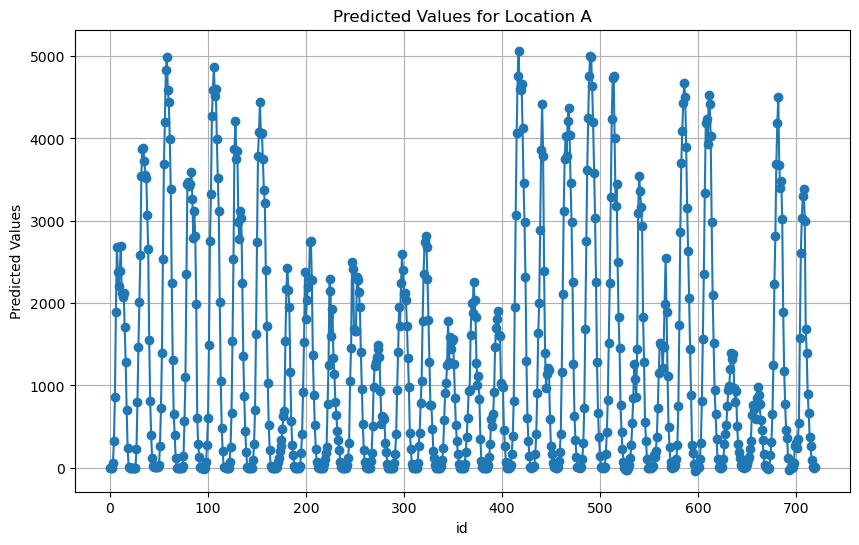

In [293]:
import matplotlib.pyplot as plt

# Assuming you have the 'submission_A' DataFrame as described
x = submission_A['id']
y = submission_A['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

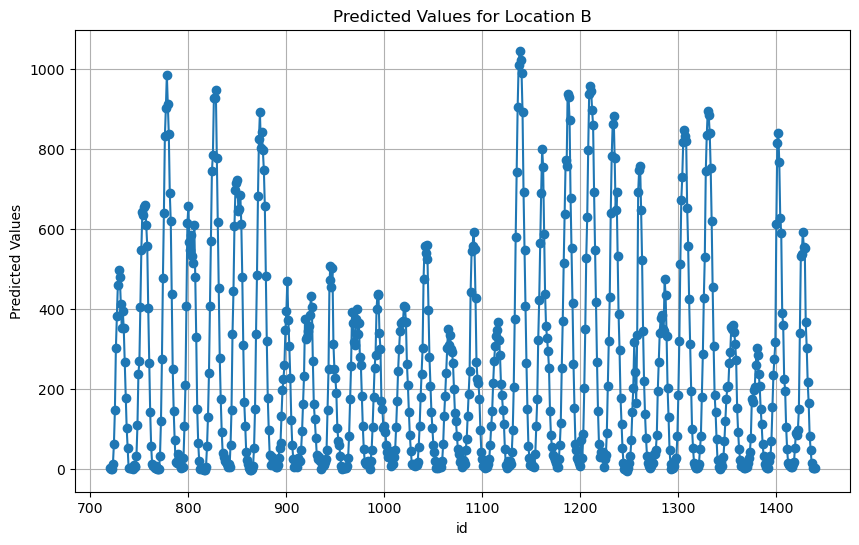

In [294]:
x = submission_B['id']
y = submission_B['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location B')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

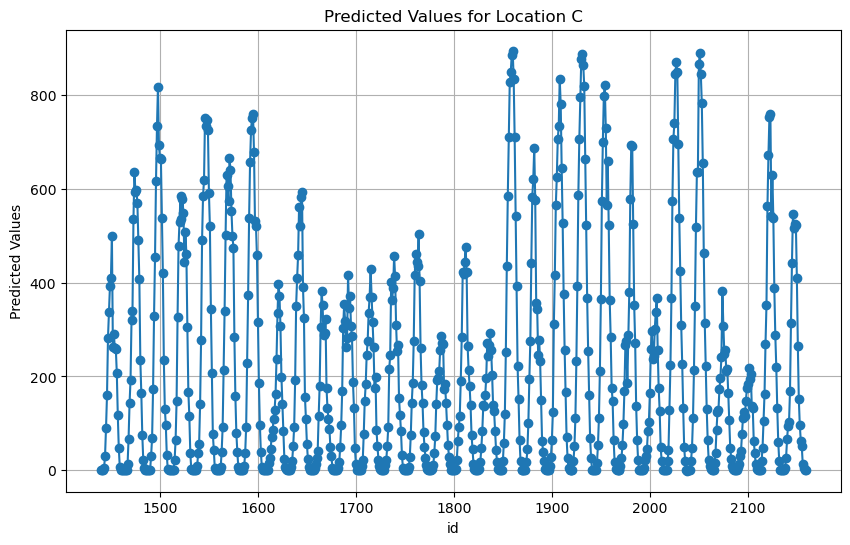

In [295]:
x = submission_C['id']
y = submission_C['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location C')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()